In [5]:
%load_ext autoreload
%autoreload 2

import itertools
import numpy as np
import matplotlib.pyplot as plt

from multiprocessing import Pool
import time
from tqdm import tqdm
import networkx as nx

from graph_generation import GenerateGraph, perturb_nx_graph
from models import GCN, view_parameters, new_parameters, modify_parameters
from train import Trainer, Dataset
from embedding import Embedding, NodeEmbedding
import experiments
from experiments import (init_GCN, init, init_model_dataset, train_take_embedding, experiment_node_embedding, 
                         elaborate_embeddings, elaborate_embeddings_2, elaborate_embedding_pergraph, separate_embedding_by_classes,
                         run_with_weights, init_with_weights, make_video, take_corr, plot_epoch, get_corrs_training)
from config_valid import Config, TrainingMode
from plot_funcs import (plot_dim1, plot_dimN, plot_correlation_error, get_metrics, plot_node_emb_1D_perclass, scatter_node_emb, 
                        plot_graph_emb_1D, plot_data_degree_sequence)
from utils import array_wo_outliers, plot_grafo, plot_grafo2

import torch
from torch_geometric.loader import DataLoader
device = torch.device('cuda')

from scipy import stats

import yaml

from plt_parameters import init_params
init_params()

#from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
#event_acc = EventAccumulator(path="./runs/lr-0.01_epochs45_bs150_neurons-1-8-2_15Sep_16-15-16")
#event_acc.Reload()
# Show all tags in the log file
#print(event_acc.Tags())
#w_times, step_nums, vals = zip(*event_acc.Scalars('Test Loss'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Overview del progetto

### Grafi regolari

In [2]:
config_file = "configurations/classification_nodeemb.yml"

In [3]:
config_c_reg = Config(config_file)
gg_reg = GenerateGraph(config_c_reg)
dataset_reg = gg_reg.initialize_dataset()

Generating dataset...
Mean connectivity for each node: 4.0 p=4
Mean connectivity for each node: 35.0 p=35
Dataset generated


In [4]:
model, trainer = init_model_dataset(config_c_reg, dataset_reg, parallel=False, verbose=False)

Initialize model
Loading Dataset...


100%|███████████████████████████████████████████████████████████████| 600/600 [00:16<00:00, 35.65it/s]


Tempo impiegato: 16.900064945220947


In [7]:
#trainer.dataset.dataset_pyg[0].id

In [5]:
#graph_embeddings_array, node_embeddings_array, model, test_loss_list, trainer = train_take_embedding(config_c_reg, dataset_reg, verbose=False)
trainer.launch_training(verbose)
graph_embeddings_array, node_embeddings_array, node_embeddings_array_id, final_output = trainer.take_embedding_all_data(type_embedding)

Before training Test loss: 0.00770855082405938
Run training for 300 epochs
Epoch: 299	Test loss: 3.558787543119656e-05 		 FINE TRAINING


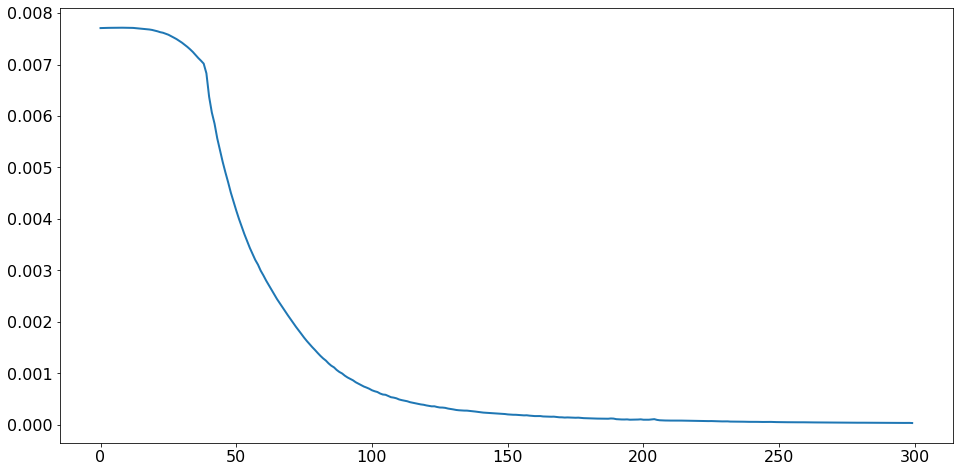

In [6]:
plt.plot(test_loss_list)

In [7]:
graph_embeddings = Embedding(graph_embeddings_array, trainer.dataset, test_loss_list, config_c_reg)
node_embeddings = NodeEmbedding(node_embeddings_array, node_embeddings_array_id, trainer.dataset, test_loss_list, config_c_reg)

node_emb_pergraphclass = node_embeddings.get_emb_per_graph_class_cm(graph_embeddings_array)

emb_perclass0 = [n for n in node_emb_pergraphclass if n.graph_label == 0]
emb_perclass1 = [n for n in node_emb_pergraphclass if n.graph_label == 1]

TypeError: 'int' object is not subscriptable

### grafi regolari con feature random

In [ ]:
# ricarico lo stesso config ma ho cambiato la property  random_node_feat: True
config_c_reg = Config(config_file)
gg_reg = GenerateGraph(config_c_reg)
dataset_reg = gg_reg.initialize_dataset()

In [ ]:
graph_embeddings_array, node_embeddings_array, model, test_loss_list, trainer = train_take_embedding(config_c_reg, dataset_reg, verbose=False)

##### aumento la p della seconda classe

In [ ]:
# ricarico lo stesso config ma ho cambiato la property  random_node_feat: True
config_c_reg = Config(config_file)
gg_reg = GenerateGraph(config_c_reg)
dataset_reg = gg_reg.initialize_dataset()

In [ ]:
graph_embeddings_array, node_embeddings_array, model, test_loss_list, trainer = train_take_embedding(config_c_reg, dataset_reg, verbose=False)

In [ ]:
### verifico che le feature dei nodi sia random
trainer.dataset.dataset_pyg[0].x

### Grafi regolari con pesi random uniform

In [ ]:
# ricarico lo stesso config ma ho cambiato la property  random_node_feat: True
config_c_reg = Config(config_file)
gg_reg = GenerateGraph(config_c_reg)
dataset_reg = gg_reg.initialize_dataset()

In [ ]:
model, trainer = init_model_dataset(config_c_reg, dataset_reg, parallel=False, verbose=False)

In [ ]:
new_par = new_parameters(model, "uniform")
modify_parameters(model, new_par)

In [ ]:
trainer.launch_training(verbose)
graph_embeddings_array, node_embeddings_array, node_embeddings_array_id, final_output = trainer.take_embedding_all_data(type_embedding)

### Grafi regolari perturbati, feature costante = 1.0

In [ ]:
config_file = "configurations/classification_nodeemb.yml"
config_c_reg = Config(config_file)  # yml file aggiornato con random feat = False

In [ ]:
gg_reg = GenerateGraph(config_c_reg)
dataset_reg = gg_reg.initialize_dataset()

In [ ]:
gg_reg.perturb_dataset(125, verbose=False) # cambia il dataset_list interno alla classe di dataset

In [ ]:
ntipo = config_c_reg.conf['graph_dataset']['Num_grafi_per_tipo']
ntipo

In [ ]:
print(round(np.array([nx.to_numpy_matrix(t).sum(axis=1).mean() for t in dataset_reg.dataset_list[:ntipo]]).mean(), 3))

In [ ]:
print(round(np.array([nx.to_numpy_matrix(t).sum(axis=1).mean() for t in dataset_reg.dataset_list[ntipo:]]).mean(), 3))

In [ ]:
model, trainer = init_model_dataset(config_c_reg, dataset_reg, verbose=False)

In [ ]:
trainer.launch_training(verbose)
graph_embeddings_array, node_embeddings_array, node_embeddings_array_id, final_output = trainer.take_embedding_all_data(type_embedding)

In [ ]:
graph_embeddings = Embedding(graph_embeddings_array, trainer.dataset, test_loss_list, config_c_reg)
node_embeddings = NodeEmbedding(node_embeddings_array, trainer.dataset, test_loss_list, config_c_reg)
num_emb_neurons = model.convs[-1].out_channels

In [ ]:
get_metrics(graph_embeddings, num_emb_neurons) #plt.figure(figsize=(18, 6))

In [ ]:
### plot 

In [ ]:

plt.scatter(node_embeddings.embeddings_array[:,0], node_embeddings.embeddings_array[:,1], s=0.01, marker='.')

In [ ]:
plt.figure(figsize=(18, 6))
plt.scatter(graph_embeddings.embeddings_array[:,0], graph_embeddings.embeddings_array[:,1], s=4.5, marker='.')

##### Plot delle metriche e degli embedding in funzione dei neuroni e dei layer

### Erdos-Renyi

In [6]:
config_file = "configurations/classification2.yml"
config_c_er = Config(config_file)
gg_er = GenerateGraph(config_c_er)
dataset_er = gg_er.initialize_dataset()

KeyError: 'GCNneurons_per_layer'

In [ ]:
#nx.to_numpy_array(dataset_er.dataset_list[0]).sum(axis=1)

In [ ]:
graph_embeddings_array, node_embeddings_array, model, test_loss_list, trainer = train_take_embedding(config_c_er, dataset_er)

In [ ]:
graph_embeddings = Embedding(graph_embeddings_array, trainer.dataset, test_loss_list, config_c_er)
node_embeddings = NodeEmbedding(node_embeddings_array, trainer.dataset, test_loss_list, config_c_er)

In [ ]:
node_embeddings.embeddings_array.shape, graph_embeddings.embeddings_array.shape

In [ ]:
node_embeddings.get_emb_pergraph_cost()

In [ ]:
def node_emb_perclass(classe=[1., 0.]):
    node_emb_class = []
    for i,n in enumerate(node_embeddings.node_emb_pergraph):
        if all(trainer.dataset.labels[i] == classe):
            node_emb_class.extend(n)
    return np.array(node_emb_class)

node_emb_class1 = node_emb_perclass([1., 0.])
node_emb_class2 = node_emb_perclass([0., 1.])


In [ ]:
plt.figure(figsize=(18, 6))
plt.scatter(node_emb_class2[:,0], node_emb_class2[:,1], s=0.01, marker='.', color='red');
plt.scatter(node_emb_class1[:,0], node_emb_class1[:,1], s=0.01, marker='.', color='blue');
plt.show()

In [ ]:
plt.figure(figsize=(18, 6))
plt.scatter(graph_embeddings.embeddings_array[:,0], graph_embeddings.embeddings_array[:,1], s=0.1, marker='.')

##### Plot delle metriche e degli embedding in funzione dei neuroni e dei layer

###### caso Classificazione:  difference of means of distances clusters

###### caso Regressione:  correlazione e plot con le classi se non continuous

# Configuration Model

### Con mean pool aggregator

In [2]:
config_file = "configurations/classification_cm.yml"
dataset, model, trainer, config_c = init(config_file)

Create dataset
Generating dataset...
Dataset generated
Initialize model


In [ ]:
G1 = dataset_cm.dataset_list[1]
plot_grafo2(G1, iterations=1000) # sizes=sizes, edges_weights=edges_weights,

In [ ]:
G1 = dataset_cm.dataset_list[1]
G1[0]

In [ ]:
print(len(G1.nodes()))
actual_degrees = [d for v, d in G1.degree()]
plt.loglog(*np.unique(actual_degrees, return_counts=True), marker='.');
plt.loglog()

In [ ]:
G2 = dataset_cm.dataset_list[550]
plot_grafo2(G2, iterations=1000)

In [ ]:
G2 = dataset_cm.dataset_list[520]
print(len(G2.nodes()))
actual_degrees = [d for v, d in G2.degree()]
plt.loglog(*np.unique(actual_degrees, return_counts=True), marker='.');

In [3]:
percentage_train = config_c.conf['training']['percentage_train']
trainer.load_dataset(dataset, percentage_train, parallel=False)

100%|███████████████████████████████████████████████████████████████| 600/600 [00:48<00:00, 12.41it/s]


Tempo impiegato: 48.462727069854736


In [5]:
trainer.launch_training(verbose)
graph_embeddings_array, node_embeddings_array, node_embeddings_array_id, final_output = trainer.take_embedding_all_data(type_embedding)

Before training Test loss: 0.015401361054844326
Run training for 50 epochs
Epoch: 49	Test loss: 0.007574184735616048 		 FINE TRAINING


In [9]:
emb_perclass0, emb_perclass1 = elaborate_embeddings(config_c, graph_embeddings_array, model, node_embeddings_array, node_embeddings_array_id, test_loss_list, trainer)

ValueError: y has more than 2 dimensions

### Correlazione tra node embedding e sequenza di grado

In [ ]:
for j in range(0,tot//2):
    emb_i = node_embeddings.node_emb_pergraph[j]
    class_i = np.array(node_embeddings.original_class[j])
    plt.scatter(emb_i, class_i, marker='.', color='blue', alpha=0.02)
for j in range(tot//2,tot):
    emb_i = node_embeddings.node_emb_pergraph[j]
    class_i = np.array(node_embeddings.original_class[j])
    plt.scatter(emb_i, class_i, marker='.', color='red', alpha=0.01)
plt.xlabel('Node Emb. values', fontsize=18);
plt.ylabel('Degree sequence', fontsize=16);
plt.show()

### Sequenza di grado

In [ ]:
plt.figure(figsize=(12, 6))
tot = len(trainer.dataset.dataset_pyg)
for j in range(0,tot//2):
    plt.loglog(*np.unique(node_embeddings.original_class[j], return_counts=True), c='blue', alpha=0.01)
for j in range(tot//2,tot):
    plt.loglog(*np.unique(node_embeddings.original_class[j], return_counts=True), c='red', alpha=0.01) 
    plt.xlabel('Degrees', fontsize=16);
plt.ylabel('Number of nodes', fontsize=16);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);

In [ ]:
for j in range(0,tot//2):
    actual_degrees_sorted = sorted(node_embeddings.original_class[j], reverse=True)
    plt.plot(actual_degrees_sorted, '.', c='blue', alpha=0.01)
for j in range(tot//2,tot):    
    actual_degrees_sorted = sorted(node_embeddings.original_class[j], reverse=True)
    plt.plot(actual_degrees_sorted, '.', c='red', alpha=0.01)

### Embedding di nodo 

In [ ]:
for j in range(0,tot//2):
    plt.loglog(*np.unique(node_embeddings.node_emb_pergraph[j].flatten(), return_counts=True), '.', c='blue', alpha=0.01)
for j in range(tot//2,tot):
    plt.loglog(*np.unique(node_embeddings.node_emb_pergraph[j].flatten(), return_counts=True), '.', c='red', alpha=0.01) 

In [ ]:
plt.figure(figsize=(12, 6))
for j in range(0,tot//2):
    nodeemb_sorted = sorted(node_embeddings.node_emb_pergraph[j], reverse=True)
    plt.plot(nodeemb_sorted, '.', c='blue', alpha=0.02)
for j in range(tot//2,tot):
    nodeemb_sorted = sorted(node_embeddings.node_emb_pergraph[j], reverse=True)
    plt.plot(nodeemb_sorted, '.', c='red', alpha=0.01)
plt.xlabel('idx Node Emb.', fontsize=16);
plt.ylabel('Value Node Emb.', fontsize=16);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);

In [ ]:
plt.figure(figsize=(14, 6))
plt.hist(node_embeddings.embeddings_array, bins = 180); #, s=0.01, marker='.')

In [ ]:
plt.figure(figsize=(14, 6))
#plt.scatter(graph_embeddings.embeddings_array[:,0], graph_embeddings.embeddings_array[:,1], s=0.1, marker='.')
plt.hist(graph_embeddings.embeddings_array, bins = 180);

### graph embedding VS degree max

In [ ]:
plt.scatter(graph_embeddings.embeddings_array, graph_embeddings.max_degree, marker='.', alpha=0.5)
plt.xlabel('Graph Emb.', fontsize=16);
plt.ylabel('Max degree', fontsize=16);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);

### Riprovo togliendo il mean pool dal modello - non si può togliere o ridurre la dimensione in modo graduale

In [ ]:
config_file = "configurations/classification_cm.yml"
config_c_cm = Config(config_file)

In [ ]:
gg_cm = GenerateGraph(config_c_cm)
dataset_cm = gg_cm.initialize_dataset()

In [ ]:
model = init_GCN(config_c_cm, verbose=False)

In [ ]:
model, trainer = init_model_dataset(config_c_cm, dataset_cm, verbose=False)

In [ ]:
graph_embeddings_array, node_embeddings_array, node_embeddings_array_id, model, test_loss_list, trainer = train_take_embedding_alreadyinit(trainer, model, config_c_cm)

In [ ]:
graph_embeddings = Embedding(graph_embeddings_array, trainer.dataset, test_loss_list, config_c_cm)
node_embeddings = NodeEmbedding(node_embeddings_array, trainer.dataset, test_loss_list, config_c_cm)

In [ ]:
node_embeddings.get_average_corr_nodeemb()

In [ ]:
#### se il penultimo layer lo metto uguale a 1 (dimensione finale del node embedding) non riesce a imparare, (perché deve riproiettare verso 2?)